In [2]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

import os.path
import numpy as np
import matplotlib.pyplot as plt
from source.services.fits_data_unpack_service import FitsDataUnpackService
from source.services.fits_file_load_service import FitsFileLoadService
from source.util import lekid_analysis_tools
from source.util import data_array_analysis_tools



In [3]:
directory = r"C:\Python_Projects\Analysis\general_device_analysis\data"
filename = "S21_Segmented_BTEMP0000_mK_POW0.0_dB_ATT50.0_dB.fits"
file_path = os.path.join(directory, filename)
expected_f0_filename = r"C:\Python_Projects\Gdspy Projects\SPT_SLIM\slim_v1\trio_f0_array.txt"
expected_f0_file_path = os.path.join(directory, expected_f0_filename)

fit_model = "skewed"  # Boolean to define which model is used for fitting, "skewed" or "non-linear"
plot_fits = False  # Boolean to plot each kids fit.
save_figures = False  # Boolean to save the plots.
show_kid_labels = True  # Boolean to add kid labels to the segmented vna sweep plot.
qr_mask_min_bound = 0.0
qr_mask_max_bound = 1e7
qc_mask_min_bound = 0.0
qc_mask_max_bound = 1e7
qi_mask_min_bound = 0.0
qi_mask_max_bound = 1e6



Sweep Data Missing Field: SETBASET
Number of KID tones: 355
Data file attenuation values:
Room temperature attenuation = 2.0
Variable Room temperature attenuation = 50.0dB
Cold attenuation = 20.0dB
Ultra-cold attenuation = 10.0dB
Output attenuation = 0.0dB
Total Amplifier Gain = 0dB
KID72: Qi = 1.07E+06
KID73: Qi = 1.64E+06
KID114: Qi = 1.08E+06
KID117: Qi = 8.42E+06
KID127: Qi = 1.16E+06
KID139: Qi = 1.35E+06
KID171: Qi = 5.78E+06
KID172: Qi = 1.02E+06
KID268: Qi = 9.52E+06
KID277: Qi = 1.16E+06
KID282: Qi = 1.18E+06
KID322: Qi = 1.02E+06
KID325: Qi = 1.20E+06
KID334: Qi = 1.03E+06
KID354: Qi = 1.04E+06


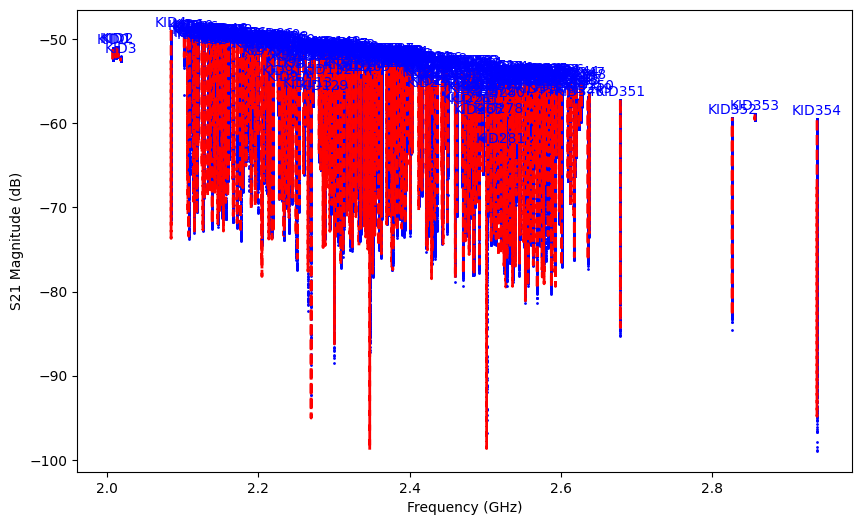

In [4]:

fits_vna_sweep = FitsFileLoadService.load_fits_vna_sweep_file(file_path=file_path)
frequency_array = fits_vna_sweep.data.frequency_array
s21_complex = fits_vna_sweep.data.get_iq_array()

number_of_tones = fits_vna_sweep.header.number_of_tones
print(f"Number of KID tones: {number_of_tones}")
fits_vna_sweep.header.print_attenuation_values()

# Split data into sub arrays corresponding to each kid:
frequency_array = np.split(frequency_array, number_of_tones)
s21_magnitude = np.abs(np.split(s21_complex, number_of_tones))

f0_array = []
qr_array = []
qc_array = []
qi_array = []

plt.figure(figsize=(10, 6))
for count, kid_s21 in enumerate(s21_magnitude):
    plt.plot(
        frequency_array[count] * 1e-9,
        20 * np.log10(kid_s21),
        linestyle="none",
        marker="o",
        color="b",
        markersize="1",
    )
    if show_kid_labels:
        plt.text(
            np.median(frequency_array[count]) * 1e-9,
            np.max(20 * np.log10(kid_s21)) + 0.5,
            f"KID{count}",
            fontsize=10,
            color="b",
            horizontalalignment="center",
        )

    # TODO: Add logic to rerun fit with different Q if errors are too large.
    if fit_model == "skewed":
        fit_result_dict = lekid_analysis_tools.fit_skewed_lorentzian(
            frequency_array=frequency_array[count],
            data_array=kid_s21,
            qc_guess=1e5,
            qi_guess=1e5,
            f0_guess=None,
            fit_fraction=0.9,
            normalise=False,
            plot_db=True,
            plot_title=f"Skewed (Pete fitter) fit: KID {count}",
            plot_graph=False,
        )
        s21_fit = lekid_analysis_tools.skewed_lorentzian(
            frequency_array=frequency_array[count],
            f0=fit_result_dict["f0"][0],
            qi=fit_result_dict["qi"][0],
            qc_real=fit_result_dict["qc_real"][0],
            qc_imag=fit_result_dict["qc_imag"][0],
            amp=fit_result_dict["amp"][0],
        )
        plt.plot(
            frequency_array[count] * 1e-9,
            20 * np.log10(s21_fit),
            linewidth=2,
            linestyle="--",
            color="r",
        )

        if fit_result_dict["qi"][0] > 1e6:
            qi = fit_result_dict["qi"][0]
            print(f"KID{count}: Qi = {qi:.2E}")

    # Store f0 and quality factor data.
    f0_array.append(fit_result_dict["f0"][0])
    qr_array.append(fit_result_dict["qr"][0])
    qc_array.append(fit_result_dict["qc"][0])
    qi_array.append(fit_result_dict["qi"][0])

plt.xlabel("Frequency (GHz)")
plt.ylabel("S21 Magnitude (dB)")
if save_figures:
    plt.savefig(
        "..\\..\\Figures\\"
        + f"{fits_vna_sweep.header.dut}_segmented_vna_sweep_KID_Fits"
    )
plt.show()

f0_array = np.array(f0_array)
qr_array = np.array(qr_array)
qc_array = np.array(qc_array)
qi_array = np.array(qi_array)

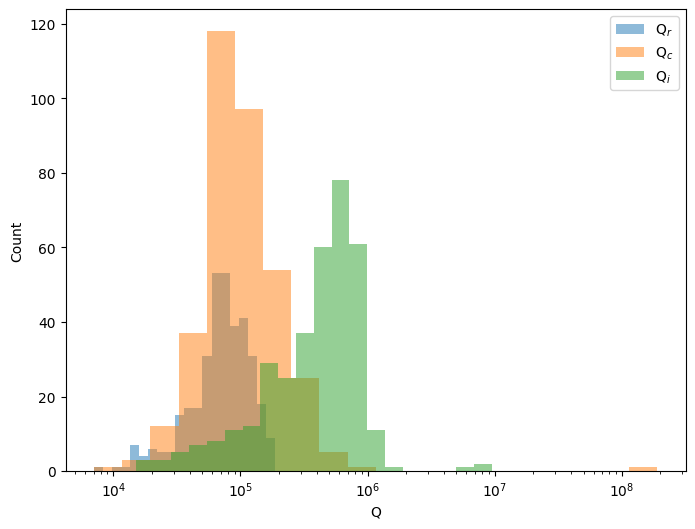

Mean Qr: 7.76E+04
Mean Qc: 1.23E+05
Mean Qi: 4.47E+05
Data points removed by mask: 16


In [5]:
########################################################################################################################

# Plot histogram of Q distribution:

plt.figure(figsize=(8, 6))
_, qr_bins = np.histogram(np.log10(qr_array + 1), bins=20)
_, qi_bins = np.histogram(np.log10(qi_array + 1), bins=20)
_, qc_bins = np.histogram(np.log10(qc_array + 1), bins=20)
plt.hist(qr_array, bins=10**qr_bins, alpha=0.5, label="Q$_r$")
plt.hist(qc_array, bins=10**qc_bins, alpha=0.5, label="Q$_c$")
plt.hist(qi_array, bins=10**qi_bins, alpha=0.5, label="Q$_i$")
# plt.hist(qr_array, bins="auto", alpha=0.5, label="Q$_r$")
# plt.hist(qc_array, bins="auto", alpha=0.5, label="Q$_c$")
# plt.hist(qi_array, bins="auto", alpha=0.5, label="Q$_i$")
plt.legend()
plt.xlabel("Q")
plt.ylabel("Count")
plt.xscale("log")
if save_figures:
    plt.savefig(
        "..\\..\\Figures\\"
        + f"{fits_vna_sweep.header.dut}_segmented_vna_sweep_Q_histogram"
    )
plt.show()

# Create mask to remove data from averaging calculations based on invalid Q values.
# Mask each qr, qc, qi array:
mask = data_array_analysis_tools.make_inequality_data_mask(
    qr_array, min_bound=qr_mask_min_bound, max_bound=qr_mask_max_bound, mask=None
)
mask = data_array_analysis_tools.make_inequality_data_mask(
    qc_array, min_bound=qc_mask_min_bound, max_bound=qc_mask_max_bound, mask=mask
)
mask = data_array_analysis_tools.make_inequality_data_mask(
    qi_array, min_bound=qi_mask_min_bound, max_bound=qi_mask_max_bound, mask=mask
)

print(f"Mean Qr: {np.mean(qr_array[mask]):.2E}")
print(f"Mean Qc: {np.mean(qc_array[mask]):.2E}")
print(f"Mean Qi: {np.mean(qi_array[mask]):.2E}")
print(f"Data points removed by mask: {qr_array.size - qr_array[mask].size}")


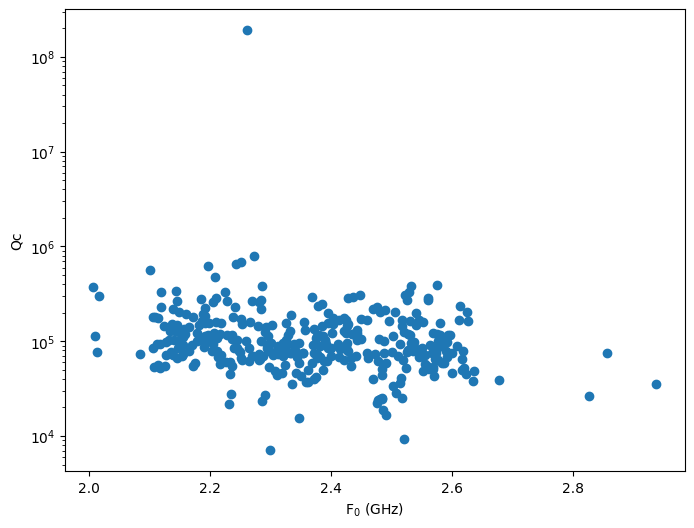

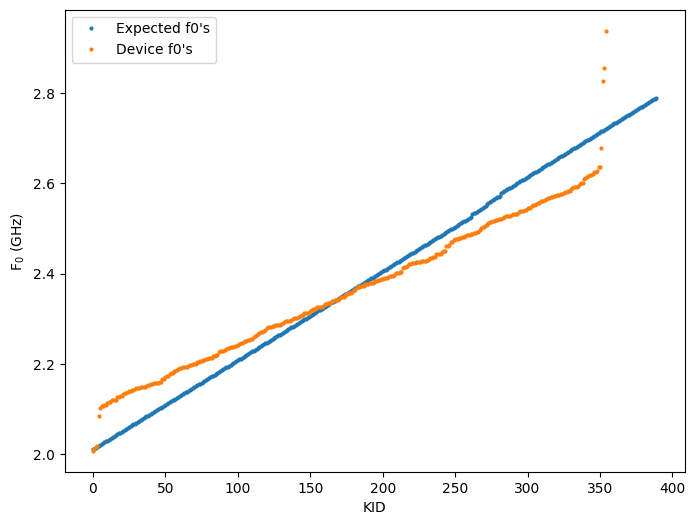

In [6]:
########################################################################################################################

# Plot Qc vs frequency:

plt.figure(figsize=(8, 6))
plt.plot(f0_array * 1e-9, qc_array, linestyle="none", marker="o", markersize="6")
plt.xlabel("F$_0$ (GHz)")
plt.ylabel("Qc")
plt.yscale("log")
if save_figures:
    plt.savefig(
        "..\\..\\Figures\\"
        + f"{fits_vna_sweep.header.dut}_segmented_vna_sweep_qc_vs_f0"
    )
plt.show()

target_f0_array = np.sort(
    np.loadtxt(expected_f0_file_path, delimiter=",").flatten()
)

plt.figure(figsize=(8, 6))
plt.plot(
    target_f0_array * 1e-9,
    linestyle="none",
    marker="o",
    markersize="2",
    label="Expected f0's",
)
plt.plot(
    f0_array * 1e-9,
    linestyle="none",
    marker="o",
    markersize="2",
    label="Device f0's",
)
plt.xlabel("KID")
plt.ylabel("F$_0$ (GHz)")
plt.legend()
if save_figures:
    plt.savefig(
        "..\\..\\Figures\\" + f"{fits_vna_sweep.header.dut}_segmented_vna_sweep_f0s"
    )
plt.show()

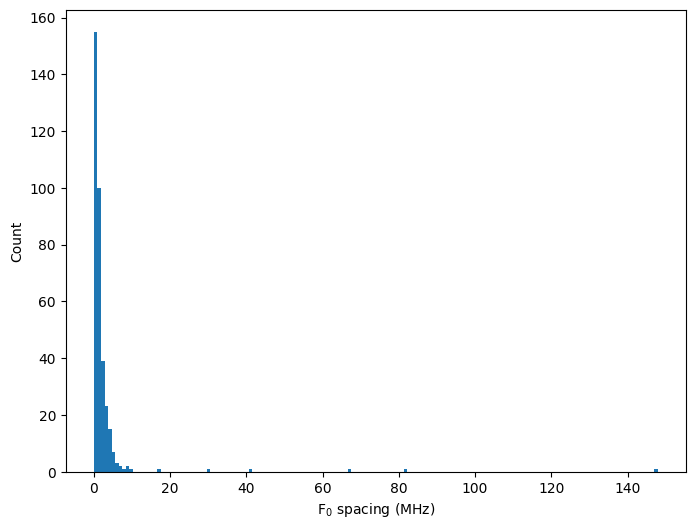

In [7]:
########################################################################################################################

# Create histogram of f0 spacing

f0_spacing = np.abs(f0_array[:-1] - f0_array[1:])
# _, f0_bins = np.histogram(np.log10((f0_spacing * 1e-6)), bins=40)
plt.figure(figsize=(8, 6))
# plt.hist(f0_spacing * 1e-6, bins=10 ** f0_bins)
plt.hist(f0_spacing * 1e-6, bins=160)
plt.xlabel("F$_0$ spacing (MHz)")
plt.ylabel("Count")
if save_figures:
    plt.savefig(
        "..\\..\\Figures\\"
        + f"{fits_vna_sweep.header.dut}_segmented_vna_sweep_f0_spacing_histogram"
    )
plt.show()


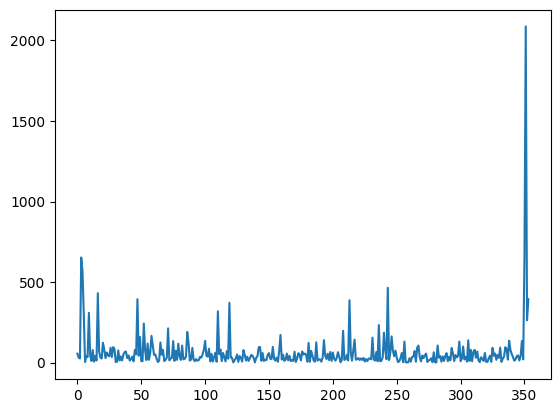

Number of KIDs = 355
Number of clashes (<0.6MHz) = 99
Number of clashes (<10 line widths) = 54
Max f0 spacing: 1.48E+08
Min f0 spacing: 5.77E+04
Mean f0 spacing: 2.63E+06


In [11]:

f0_spacing = np.diff(f0_array)

# Plot histogram of spacing interms of linewidths:
full_width_half_max = f0_array / qr_array
line_width_spacing = f0_spacing / full_width_half_max[:-1]

plt.figure()
plt.plot(line_width_spacing)
plt.show()

clash_indexes = np.where(np.diff(f0_array) * 1e-6 < 0.6)[0]
line_width_clash_indexes = np.where(line_width_spacing < 10)[0]

print("Number of KIDs = " + str(len(f0_array)))
print("Number of clashes (<0.6MHz) = " + str(len(clash_indexes)))
print("Number of clashes (<10 line widths) = " + str(len(line_width_clash_indexes)))
print(f"Max f0 spacing: {np.max(f0_spacing):.2E}")
print(f"Min f0 spacing: {np.min(f0_spacing):.2E}")
print(f"Mean f0 spacing: {np.mean(f0_spacing):.2E}")

In [12]:
idc_qr = 4.3e4
idc_line_width_spacing = f0_spacing / (f0_array/idc_qr)[-1]
line_width_clash_indexes = np.where(idc_line_width_spacing < 10)[0]

print(f"Number of clashes using IDC linewidth = {line_width_clash_indexes.size}")

Number of clashes using IDC linewidth = 115
